In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed=1)
N = 100
K = 3

T3 = np.zeros((N, 3), dtype = np.uint8)
T2 = np.zeros((N, 2), dtype = np.uint8)
X = np.zeros((N, 2))
X_range0 = [-3, 3]
X_range1 = [-3, 3]
Mu = np.array([[-0.5, -0.5], [0.5, 1], [1, -0.5]])
Sig = np.array([[0.7, 0.7], [0.8, 0.3], [0.3, 0.8]])
Pi = np.array([0.4, 0.8, 1])

for n in range(N):
    wk = np.random.rand()
    for k in range(K):
        if wk < Pi[k]:
            T3[n ,k] = 1
            break
    for k in range(2):
        X[n, k] = np.random.randn() * Sig[T3[n,:]==1, k] + Mu[T3[n,:]==1, k]
        
T2[:, 0] = T3[:, 0]
T2[:, 1] = T3[:, 1] | T3[:, 2]

print(X[:5, :])
print(T2[:5, :])
print(T3[:5, :])

[[-0.14173827  0.86533666]
 [-0.86972023 -1.25107804]
 [-2.15442802  0.29474174]
 [ 0.75523128  0.92518889]
 [-1.10193462  0.74082534]]
[[0 1]
 [1 0]
 [1 0]
 [0 1]
 [1 0]]
[[0 1 0]
 [1 0 0]
 [1 0 0]
 [0 1 0]
 [1 0 0]]


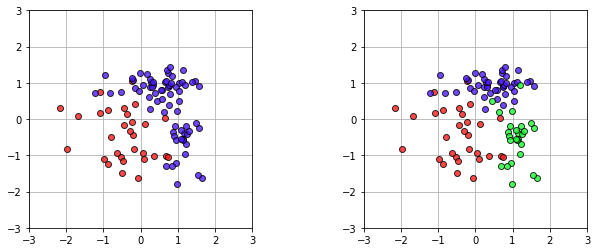

In [4]:
def show_data2(x, t):
    wk, K = t.shape
    c = [[1, 0.1, 0.1], [0.3, 0.1, 1], [0.1, 1, 0.2]]
    for k in range(K):
        plt.plot(x[t[:, k]==1, 0], x[t[:, k]==1, 1], linestyle = 'none', markeredgecolor = 'black', marker = 'o', color = c[k], alpha = 0.8)
        plt.grid(True)
        
plt.figure(figsize = (10, 4))
plt.subplots_adjust(wspace = 0.5)
plt.subplot(1, 2, 1)
show_data2(X, T2)
plt.xlim(X_range0)
plt.ylim(X_range1)

plt.subplot(1, 2, 2)
show_data2(X, T3)
plt.xlim(X_range0)
plt.ylim(X_range1)
plt.show()

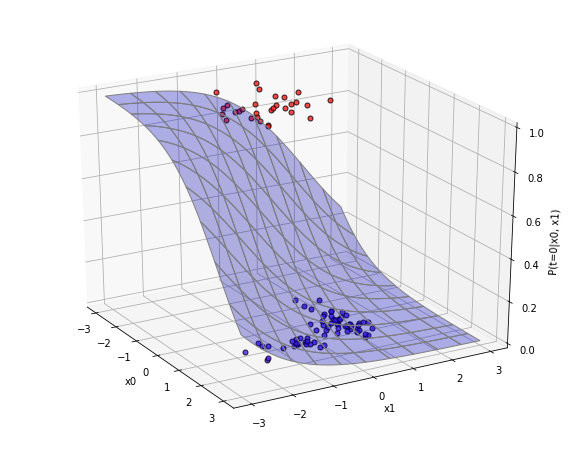

In [19]:
def logistic2(x0, x1, w):
    y = 1 / (1 + np.exp(-w[0]*x0 - w[1]*x1 - w[2]))
    return y

from mpl_toolkits.mplot3d import axes3d

def show3d_logistic2(ax, w):
    xn = 50
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    y = logistic2(xx0, xx1, w)
    ax.plot_surface(xx0, xx1, y, color='blue', edgecolor='gray', rstride=5, cstride=5, alpha=0.3)

def show_data2_3d(ax, x, t):
    c = [[1, 0.1, 0.1], [0.3, 0.1, 1]]
    for i in range(2):
        ax.plot(x[t[:, i]==1, 0], x[t[:, i]==1, 1], 1-i, marker='o', color=c[i], markeredgecolor='black', linestyle='none', markersize=5, alpha=0.8)
    ax.view_init(elev=25, azim = -30)
    ax.set_xlabel('x0')
    ax.set_ylabel('x1')
    ax.set_zlabel('P(t=0|x0, x1)')

plt.figure(figsize=(10, 8))
Ax = plt.subplot(1, 1, 1, projection='3d')
W = [-1, -1, -1]
show3d_logistic2(Ax, W)
show_data2_3d(Ax, X, T2)

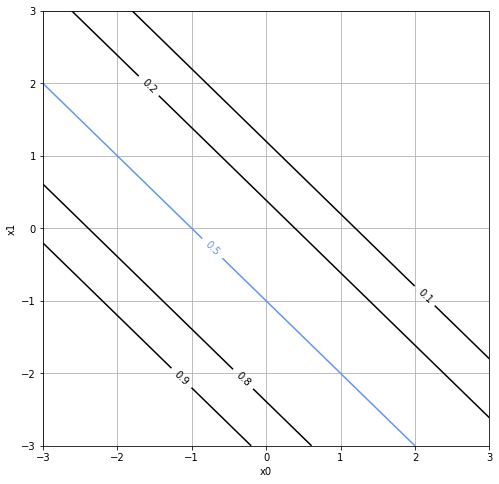

In [21]:
def show_contour_logistic2(w):
    xn = 30
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    xx0, xx1 = np.meshgrid(x0, x1)
    y = logistic2(xx0, xx1, w)
    cont = plt.contour(xx0, xx1, y, levels = (0.1, 0.2, 0.5, 0.8, 0.9), colors = ['k', 'k', 'cornflowerblue', 'k', 'k'])
    cont.clabel(fmt = '%.1f', fontsize = 10)
    plt.xlabel('x0')
    plt.ylabel('x1')
    plt.grid(True)
    
plt.figure(figsize = (8, 8))
W = [-1, -1, -1]
show_contour_logistic2(W)

In [23]:
def cee_logistic2(w, x, t):
    X_n = x.shape[0]
    y = logistic2(x[:, 0], x[:, 1], w)
    cee = 0
    for n in range(len(y)):
        cee = cee - (t[n, 0] * np.log(y[n]) + (1-t[n, 0])*np.log(1-y[n]))
    cee = cee / X_n
    return cee
def dcee_logistic2(w, x, t):
    X_n = x.shape[0]
    y = logistic2(x[:, 0], x[:, 1], w)
    dcee = np.zeros(3)
    for n in range(len(y)):
        dcee[0] = dcee[0] + (y[n]-t[n, 0])*x[n, 0]
        dcee[1] = dcee[1] + (y[n]-t[n, 0])*x[n, 1]
        dcee[2] = dcee[2] + (y[n]-t[n, 0])
    dcee = dcee / X_n
    return dcee

W = [-1, -1, -1]
dcee_logistic2(W, X, T2)

array([ 0.10272008,  0.04450983, -0.06307245])

w0 = -3.70, w1 = -2.54, w2 = -0.28
CEE = 0.22


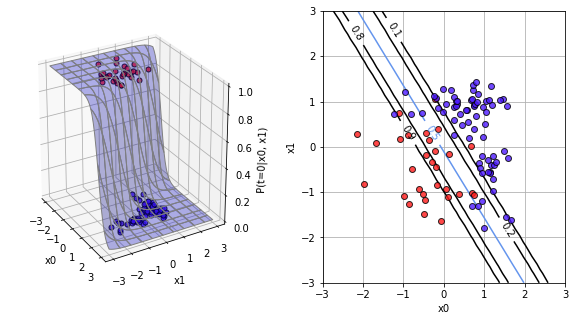

In [27]:
from scipy.optimize import minimize

def fit_logistic2(w_init, x, t):
    res = minimize(cee_logistic2, w_init, args=(x, t), jac = dcee_logistic2, method = "CG")
    return res.x

plt.figure(1, figsize=(10, 5))
plt.subplots_adjust(wspace = 0.3)

Ax = plt.subplot(1, 2, 1, projection = '3d')
W_init = [-1, 0, 0]
W = fit_logistic2(W_init, X, T2)
print("w0 = {0:.2f}, w1 = {1:.2f}, w2 = {2:.2f}".format(W[0], W[1], W[2]))
show3d_logistic2(Ax, W)

show_data2_3d(Ax, X, T2)
cee = cee_logistic2(W, X, T2)
print("CEE = {0:.2f}".format(cee))

Ax = plt.subplot(1, 2, 2)
show_data2(X, T2)
show_contour_logistic2(W)
plt.show()

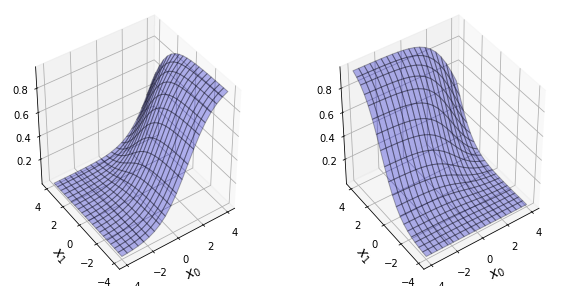

In [29]:
def softmax(x0, x1, x2):
    u = np.exp(x0) + np.exp(x1) + np.exp(x2)
    return np.exp(x0)/u, np.exp(x1)/u, np.exp(x2)/u

xn = 20
x0 = np.linspace(-4, 4, xn)
x1 = np.linspace(-4, 4, xn)
y = np.zeros((xn, xn, 3))
for i0 in range(xn):
    for i1 in range(xn):
        y[i1, i0, :] = softmax(x0[i0], x1[i1], 1)
        
xx0, xx1 = np.meshgrid(x0, x1)
plt.figure(figsize = (10, 5))
for i in range(2):
    ax = plt.subplot(1, 2, i+1, projection='3d')
    ax.plot_surface(xx0, xx1, y[:, :, i], rstride=1, cstride = 1, alpha = 0.3, color = 'blue', edgecolor = 'black')
    ax.set_xlabel('$x_0$', fontsize = 14)
    ax.set_ylabel('$x_1$', fontsize = 14)
    ax.view_init(40, -125)
    
plt.show()

In [33]:
def logistic3(x0, x1, w):
    K = 3
    w = w.reshape((3, 3))
    n = len(x1)
    y = np.zeros((n, K))
    for k in range(K):
        y[:, k] = np.exp(w[k, 0]*x0 + w[k, 1]*x1 + w[k, 2])
    wk = np.sum(y, axis = 1)
    wk = y.T/wk
    y = wk.T
    return y

W = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
y = logistic3(X[:3, 0], X[:3, 1], W)
print(np.round(y, 3))

[[0.    0.006 0.994]
 [0.965 0.033 0.001]
 [0.925 0.07  0.005]]


In [34]:
def cee_logistic3(w, x, t):
    X_n = x.shape[0]
    y = logistic3(x[:,0], x[:,1], w)
    cee = 0
    N, K = y.shape
    for n in range(N):
        for k in range(K):
            cee = cee - (t[n, k]*np.log(y[n, k]))
    cee = cee / X_n
    return cee

W = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
cee_logistic3(W, X, T3)

3.9824582404787288

In [35]:
def dcee_logistic3(w, x, t):
    X_n = x.shape[0]
    y = logistic3(x[:, 0], x[:, 1], w)
    dcee = np.zeros((3, 3))
    N, K = y.shape
    for n in range(N):
        for k in range(K):
            dcee[k, :] = dcee[k, :] - (t[n, k] - y[n, k])*np.r_[x[n,:], 1]
    dcee = dcee / X_n
    return dcee.reshape(-1)

W = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
dcee_logistic3(W, X, T3)

array([ 0.03778433,  0.03708109, -0.1841851 , -0.21235188, -0.44408101,
       -0.38340835,  0.17456754,  0.40699992,  0.56759346])

[[-3.2  -2.69  2.25]
 [-0.49  4.8  -0.69]
 [ 3.68 -2.11 -1.56]]
CEE = 0.23


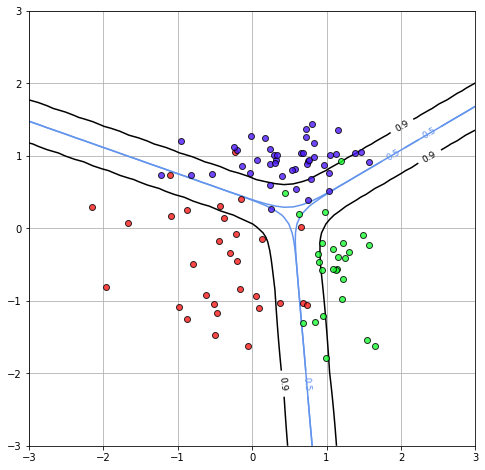

In [37]:
def fit_logistic3(w_init, x, t):
    res = minimize(cee_logistic3, w_init, args = (x, t), jac = dcee_logistic3, method = "CG")
    return res.x

def show_contour_logistic3(w):
    xn = 50
    x0 = np.linspace(X_range0[0], X_range0[1], xn)
    x1 = np.linspace(X_range1[0], X_range1[1], xn)
    
    xx0, xx1 = np.meshgrid(x0, x1)
    y = np.zeros((xn, xn, 3))
    for i in range(xn):
        wk = logistic3(xx0[:, i], xx1[:, i], w)
        for j in range(3):
            y[:, i, j] = wk[:, j]
    for j in range(3):
        cont = plt.contour(xx0, xx1, y[:, :, j], levels = (0.5, 0.9), colors = ['cornflowerblue', 'k'])
        cont.clabel(fmt = '%.1f', fontsize = 9)
    plt.grid(True)
    
W_init = np.zeros((3, 3))
W = fit_logistic3(W_init, X, T3)
print(np.round(W.reshape(3, 3), 2))
cee = cee_logistic3(W, X, T3)
print("CEE = {0:.2f}".format(cee))

plt.figure(figsize=(8, 8))
show_data2(X, T3)
show_contour_logistic3(W)
plt.show()
                  